Base pairs: [(0, 39), (1, 38), (2, 37), (3, 36), (4, 34), (5, 33), (6, 7), (8, 32), (9, 31), (10, 30), (11, 29), (12, 13), (14, 15), (16, 19), (17, 18), (20, 21), (22, 23), (24, 28), (25, 26)]
Time taken by the algorithm: 19.19 milliseconds
Memory used by matrix P: 14240.00 Bytes


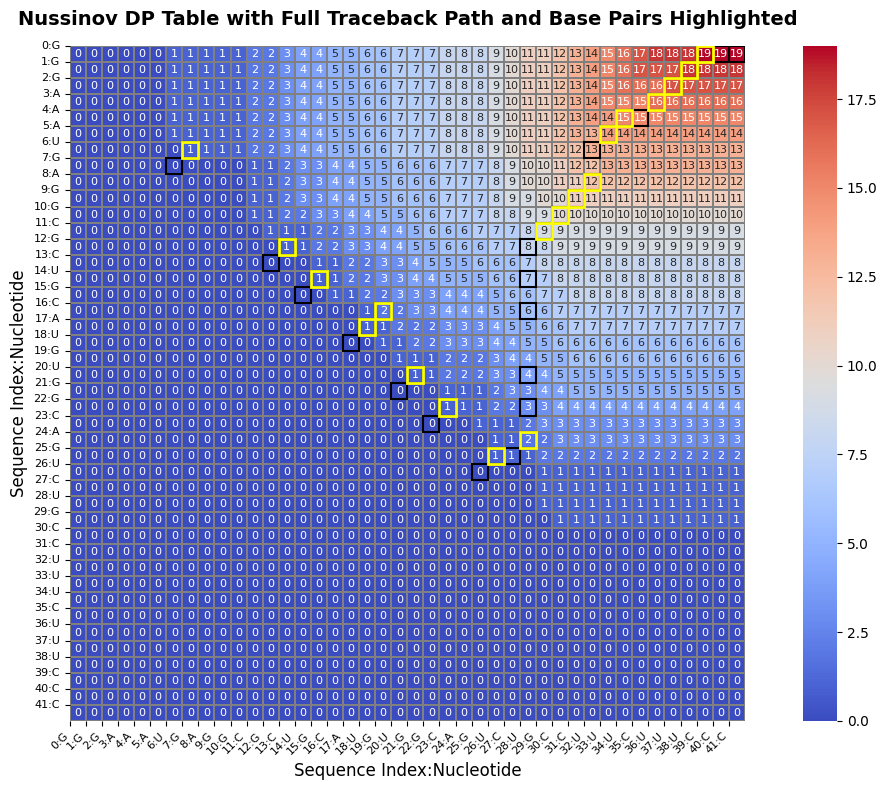

Dot-Parenthesis Notation: ((((((()((((()()(())()()(().))))))).))))..


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time

def nussinov(sequence, match_score=1, mismatch_score=0, min_loop_length=0):
    n = len(sequence)
    dp = np.zeros((n, n), dtype=int)

    # Filling DP table
    for l in range(1, n):
        for i in range(n - l):
            j = i + l
            if j - i > min_loop_length:
                match = (sequence[i], sequence[j])
                pair_score = match_score if is_complementary(match) else mismatch_score
                dp[i, j] = max(
                    dp[i + 1, j],  # i is unpaired
                    dp[i, j - 1],  # j is unpaired
                    dp[i + 1, j - 1] + pair_score if j - i > min_loop_length else 0,  # i, j paired
                    max(dp[i, k] + dp[k + 1, j] for k in range(i, j))  # bifurcation
                )

    # Traceback
    base_pairs = []
    def traceback_pairs(i, j):
        if i >= j:
            return
        elif dp[i, j] == dp[i + 1, j]:
            traceback_pairs(i + 1, j)
        elif dp[i, j] == dp[i, j - 1]:
            traceback_pairs(i, j - 1)
        elif dp[i, j] == dp[i + 1, j - 1] + (match_score if is_complementary((sequence[i], sequence[j])) else mismatch_score):
            base_pairs.append((i, j))
            traceback_pairs(i + 1, j - 1)
        else:
            for k in range(i, j):
                if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                    traceback_pairs(i, k)
                    traceback_pairs(k + 1, j)
                    break

    traceback_pairs(0, n - 1)


    dot_parenthesis = ['.' for _ in range(n)]
    for i, j in base_pairs:
        dot_parenthesis[i] = '('
        dot_parenthesis[j] = ')'
    dot_parenthesis_str = ''.join(dot_parenthesis)

    return dp, base_pairs, dot_parenthesis_str

def is_complementary(pair):
    complementary_pairs = {"AU", "UA", "GC", "CG", "GU", "UG"}
    return "".join(pair) in complementary_pairs



def visualize_dp_table_with_full_traceback(dp, sequence, base_pairs):

    n = len(sequence)
    labels = [f"{i}:{sequence[i]}" for i in range(n)]
    traceback_path = set()

    def traceback_path_cells(i, j):

        if i >= j:
            return
        if dp[i, j] == dp[i + 1, j]:
            traceback_path.add((i + 1, j))
            traceback_path_cells(i + 1, j)
        elif dp[i, j] == dp[i, j - 1]:
            traceback_path.add((i, j - 1))
            traceback_path_cells(i, j - 1)
        elif dp[i, j] == dp[i + 1, j - 1] + (1 if is_complementary((sequence[i], sequence[j])) else 0):
            traceback_path.add((i + 1, j - 1))
            traceback_path_cells(i + 1, j - 1)
        else:
            for k in range(i, j):
                if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                    traceback_path.add((i, k))
                    traceback_path.add((k + 1, j))
                    traceback_path_cells(i, k)
                    traceback_path_cells(k + 1, j)
                    break

    traceback_path.add((0, n - 1))
    traceback_path_cells(0, n - 1)

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        dp,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        cbar=True,
        square=True,
        linewidths=0.3,
        linecolor="gray",
        annot_kws={"fontsize": 8},
    )


    for (i, j) in traceback_path:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="black", lw=1.5))


    for (i, j) in base_pairs:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="yellow", lw=2))

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)


    plt.title("Nussinov DP Table with Full Traceback Path and Base Pairs Highlighted", fontsize=14, weight="bold", pad=15)
    plt.xlabel("Sequence Index:Nucleotide", fontsize=12)
    plt.ylabel("Sequence Index:Nucleotide", fontsize=12)

    plt.tight_layout()
    plt.show()

def visualize_dot_parenthesis(dot_parenthesis_str):

    print(f"Dot-Parenthesis Notation: {dot_parenthesis_str}")

def visualize_base_pairs_interactive_spiral(sequence, base_pairs):

    theta = np.linspace(0, 4 * np.pi, len(sequence))
    z = np.linspace(-2, 2, len(sequence))
    x = np.cos(theta)
    y = np.sin(theta)


    fig = go.Figure()

    nucleotide_colors = {'A': 'green', 'U': 'red', 'G': 'blue', 'C': 'purple'}
    for i, char in enumerate(sequence):
        fig.add_trace(
            go.Scatter3d(
                x=[x[i]], y=[y[i]], z=[z[i]],
                mode='markers+text',
                marker=dict(size=8, color=nucleotide_colors.get(char, 'grey')),
                text=f"{char}({i})",
                textposition='top center',
                name=f'Nucleotide {char}'
            )
        )


    for i, j in base_pairs:
        fig.add_trace(
            go.Scatter3d(
                x=[x[i], x[j]], y=[y[i], y[j]], z=[z[i], z[j]],
                mode='lines',
                line=dict(color='orange', width=4),
                name='Base Pairing'
            )
        )


    fig.update_layout(
        title=" RNA 3D Base Pairing Visualization",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        ),
        showlegend=False,
        width=1000,
        height=600
    )

    fig.show()

start_time = time.time()

# Add your sequences here
s0 = "GGGAAAUGAGGCGCUGCAUGUGGCAGUCUGCCUUUCUUUCCC"
s1 = ...
s2 = ...
s3 = ...
s4 = ...
s5 = ...

sequences = [s0, s1, s2, s3, s4, s5]

dp_table, base_pairs, dot_parenthesis_str = nussinov(sequences[0])

print("Base pairs:", base_pairs)
end_time = time.time()
elapsed_time = end_time - start_time
memory = dp_table.__sizeof__()


print(f"Time taken by the algorithm: {elapsed_time*1000:.2f} milliseconds")
print(f"Memory used by matrix P: {memory:.2f} Bytes")


# Visualizations
visualize_dp_table_with_full_traceback(dp_table, sequences[0], base_pairs)
visualize_dot_parenthesis(dot_parenthesis_str)
visualize_base_pairs_interactive_spiral(sequences[0], base_pairs)
